<a href="https://colab.research.google.com/github/gerritgr/MaskedGraphGen/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# <img src="https://mario.wiki.gallery/images/thumb/8/89/MPS_Toad_Artwork.png/170px-MPS_Toad_Artwork.png" alt="Dataset Summary" width="3%">  Batched Toad  <img src="https://mario.wiki.gallery/images/thumb/8/89/MPS_Toad_Artwork.png/170px-MPS_Toad_Artwork.png" alt="Dataset Summary" width="3%"> 


Todos:
- weightes sampling
- multi-channel
- uncertainty
- better ensable like skip one during training or learn weights
- to make network better: virutal node, degree input, spectral input, edge 
features
- fix order, e.g. based on degree

## Setup

In [1]:
import sys, os
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  os.system("pip install wandb -Uq")
  #!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html
  #os.system("pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv torch_geometric -f https://data.pyg.org/whl/torch-1.13.0+cu117.html")
  os.system("pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html")
  os.system("pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html")
  os.system("pip install -q git+https://github.com/pyg-team/pytorch_geometric.git")
  os.system("pip install pyemd")


PATH_TO_NOTEBOOK = "Batched Toad 3.ipynb"
PROJECT_NAME = "toad_double"
KEY = "e306abc657482e172a5ccc8d7c0b81bc4d297dd4"
WANDB_MODE = "online"   # "online" or "dryrun"

In [2]:
def get_wand_api_key():
  api_key = KEY
  # use   echo "your_api_key_here" > ~/api_key.txt   to write the api key to the home file dir    
  if api_key != "":
    return api_key
  home_dir = os.path.expanduser('~')
  file_path = os.path.join(home_dir, 'api_key.txt')
  with open(file_path, 'r') as file:
      api_key = file.read().strip()
  return api_key


## Imports

In [3]:
#%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100 # Set this to 300 to get better image quality
from PIL import Image # We use PIL to load images
import seaborn as sns
import imageio # to generate .gifs

# always good to have
import glob, random, os, traceback
import numpy as np
import networkx as nx
import math

# the typical pytorch imports
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn
from torch.optim import Adam
from torch.nn import Linear as Lin
from torch.nn import Sequential as Seq
from torch.nn import Linear
import torch.nn.functional as F

# PyG
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import erdos_renyi_graph, to_networkx, from_networkx
from torch_geometric.nn import GINConv
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_add_pool
from torch_geometric.loader import DataLoader

#Video
from PIL import Image, ImageDraw
#import cv2
from IPython.display import HTML
from base64 import b64encode

## Hyperparameters

In [4]:
NUM_NODES = 12 #12   
DEGREE = 3 #3
NUM_EPOCHS = 1000

NUM_SAMPLES = 1000
NUM_GRAPHS_GENERATE = 10 # 40 in compare set, but they use 10 in spectre

GENERATE_X_EPOCHS = 100

NO_EDGE_INDICATOR = 3.0
EDGE_INDICATOR = 1.0 
DUMMY = 0.0 # this node is an actual node not a placeholder for an edge
MASK = 2.0
NUM_CLASSES = 4  #todo change to 5 an

EPSILON = 0.000000001

NODE_FEATURE_EXTEND = 3

# do i need this
#BATCH_SIZE_TEST = 10

#TIME_EMBEDDING_DIM = 1

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#DEVICE = torch.device('cpu')
DEVICE


device(type='cpu')

### Seeds

In [5]:
# from stack overflow
def str_to_float(s, encoding="utf-8"):
  from zlib import crc32
  def bytes_to_float(b):
    return float(crc32(b) & 0xffffffff) / 2**32
  return bytes_to_float(s.encode(encoding))

    
def set_seeds(seed=42):
  if not "int" in str(type(seed)):
    seed = int(str_to_float(str(seed))*1000 % 100000000)
  np.random.seed(seed)
  torch.random.manual_seed(seed)
  random.seed(seed)
  torch.cuda.manual_seed_all(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  torch.backends.cudnn.deterministic = True

set_seeds()

## Weights and Biases Config

In [6]:
import wandb
wandb.login(key=get_wand_api_key())

sweep_config = {
    "name": "graph-unmasking",
    "method": "random",
    "metric": {
        "name": "graph-unmasking/gen-loss",
        "goal": "minimize",
    },
    "parameters": {
        "batch_size": {"values": [100]},  # write only
        "hidden_dim": {"values": [16,32, 64]},  
        "hidden_layer": {"values": [4,5,6]},
        "learning_rate": {"values": [0.00001,0.0001]},
        "dropout": {"values": [0.0]},
        "normalization": {"values": [True, False]},
        "model": {"values": ["pna"]},  # [ "pnamulti", "pna","pna2", "attention","transformer", "unet"]}, 
        "candidate_selection_radius": {"values": [1, 5]},
        "loss": {"values": ["bce"]},   # "loss": {"values": ["l2","l1", "bce"]}, 
        "single_pass": {"values": [True]},  
        "towers": {"values": [1, 2]},   
        "noise_probability": {"values": [0.0, 0.05, 0.1]},
        "graph_transform": {"values": [True, False]},    
        "pre_post_layers": {"values": [1]},   
        "double_inference": {"values": [True, False]}, 
    },
}

import pprint
pprint.pprint(sweep_config)
torch.set_printoptions(threshold=1000)

wandb: Currently logged in as: gerritgr (nextaid). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/gerritgrossmann/.netrc


{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'graph-unmasking/gen-loss'},
 'name': 'graph-unmasking',
 'parameters': {'batch_size': {'values': [100]},
                'candidate_selection_radius': {'values': [1, 5]},
                'double_inference': {'values': [True, False]},
                'dropout': {'values': [0.0]},
                'graph_transform': {'values': [True, False]},
                'hidden_dim': {'values': [16, 32, 64]},
                'hidden_layer': {'values': [4, 5, 6]},
                'learning_rate': {'values': [1e-05, 0.0001]},
                'loss': {'values': ['bce']},
                'model': {'values': ['pna']},
                'noise_probability': {'values': [0.0, 0.05, 0.1]},
                'normalization': {'values': [True, False]},
                'pre_post_layers': {'values': [1]},
                'single_pass': {'values': [True]},
                'towers': {'values': [1, 2]}}}


## Utils

In [7]:
def lift_nx_to_pyg(g_nx):
  import torch_geometric.transforms as T
  transform = T.Compose([T.ToUndirected()])

  # g_nx has to have node_labels 0 ... number_of_nodes-1
  num_nodes = g_nx.number_of_nodes()
  g_complete_nx = nx.complete_graph(num_nodes)

  edges_new = list()
  node_value_dict = dict()
  for v1, v2 in g_complete_nx.edges():
    v3 = (v1+1)*10000+(v2+1)*100000000000
    edges_new.append((v1, v3))
    edges_new.append((v2, v3))
    node_value_dict[v1] = DUMMY
    node_value_dict[v2] = DUMMY
    node_value_dict[v3] = EDGE_INDICATOR if g_nx.has_edge(v1,v2) else NO_EDGE_INDICATOR

  graph_new = nx.from_edgelist(edges_new)
  for node, x_value in node_value_dict.items():
    graph_new.nodes[node]['x'] = x_value

  graph_new = nx.convert_node_labels_to_integers(graph_new, ordering='sorted')

  g = from_networkx(graph_new, group_node_attrs=['x'])
  g = transform(g)  # probably unnecs.
  return g


def reduce_nx_graph(g_old):
  g_new = nx.Graph()
  for v_i in g_old.nodes():
    if g_old.nodes[v_i]['x'] == DUMMY:
      g_new.add_node(v_i)
      g_new.nodes[v_i]['x'] = DUMMY

  for v_i in g_old.nodes():
    if g_old.nodes[v_i]['x'] == EDGE_INDICATOR:
      neigh_list = list(g_old.neighbors(v_i))
      assert(len(neigh_list) == 2)
      g_new.add_edge(neigh_list[0], neigh_list[1])

  return g_new

def pyg_graph_to_nx(g_pyg):
  g_nx = to_networkx(g_pyg, node_attrs=['x'], to_undirected=True,)
  g_nx = reduce_nx_graph(g_nx)
  return g_nx

def draw_pyg(g_pyg, ax = None, filename = None):
  if ax is None:
    plt.clf()

  g_nx = pyg_graph_to_nx(g_pyg)

  node_labels = {i: g_nx.nodes[i]['x'] for i in g_nx.nodes}
  pos = nx.spring_layout(g_nx, seed=1234)
  try:
    nx.draw(g_nx, with_labels = True, labels=node_labels, ax=ax, pos=pos)
  except:
    pass
  if filename is not None:
    plt.savefig(filename, dpi=300, bbox_inches='tight')
  return g_nx


def shuffle_tensor(x):
  x = x.clone()
  x_shape = x.shape
  x = x.flatten()
  x = x[torch.randperm(x.numel())]
  return x.reshape(x.shape)


def note_features_to_one_hot(x):
  # create indicator vector for NUM_CLASSES classes, values outside are set to all zeros (first to special class that then gets truncated)
  x_cut = torch.where((x < -0.1) | (x > NUM_CLASSES-0.5), torch.tensor(NUM_CLASSES, device = DEVICE, dtype=torch.float), x)
  x_one_hot = torch.zeros(x.shape[0], NUM_CLASSES+1, device = DEVICE)
  x_one_hot.scatter_(1, x_cut.round().long().view(-1).unsqueeze(1), 1)
  x_one_hot = x_one_hot[:,0:NUM_CLASSES]
  return x_one_hot

def global_mask_pool(x, x_in, batch):
  mask_indicator = torch.lt(torch.sum(x_in, dim=1), 0.5).view(-1, 1)
  x = x * mask_indicator
  x = global_add_pool(x, batch)
  return x 


def flip_edges_randomly(tensor, probability):
  if probability < EPSILON:
    return tensor

  # Find the positions where the tensor has values 1.0 or 3.0
  ones_positions = (tensor == EDGE_INDICATOR).to(DEVICE)
  threes_positions = (tensor == NO_EDGE_INDICATOR).to(DEVICE)

  # Generate a random binary mask for switching values
  mask = torch.rand(tensor.shape, device=DEVICE) < probability

  # Switch 1.0s to 3.0s using the random binary mask
  tensor = torch.where(ones_positions & mask, torch.tensor(NO_EDGE_INDICATOR, device=DEVICE), tensor)

  # Switch 3.0s to 1.0s using the inverted random binary mask
  tensor = torch.where(threes_positions & mask, torch.tensor(EDGE_INDICATOR, device=DEVICE), tensor)

  return tensor

def extend_node_features(x, edge_index, batch):
  assert(NODE_FEATURE_EXTEND == 3)

  num_graphs = batch.max()+1
  num_nodes = x.shape[0]
  degree_feature = torch.zeros([num_nodes, NODE_FEATURE_EXTEND], device=DEVICE)
  for i in range(edge_index.shape[1]):
    src_node = edge_index[0,i]
    target_node = edge_index[1,i]
    # if src is real node and connection is edge indicator 
    if x[src_node, round(DUMMY)].item() > 0.5 and x[target_node, round(EDGE_INDICATOR)].item() > 0.5:
      degree_feature[src_node,0] += 1.0
    if x[src_node, round(DUMMY)].item() > 0.5 and x[target_node, round(MASK)].item() > 0.5:
      degree_feature[src_node,1] += 1.0
  for i in range(num_graphs):
    num_mask_in_this_graph = torch.sum(x[batch == i,round(MASK)])
    degree_feature[batch == i, 2] = num_mask_in_this_graph
  x = torch.cat([x, degree_feature], dim=1)

  return x

In [8]:
import torch_geometric.transforms as T
transform = T.Compose([T.ToUndirected()])

edge_index = torch.tensor([[0, 1, 2, 3, 1, 2, 3],
                           [1, 2, 3, 1, 0, 1, 2]], dtype=torch.long).to(DEVICE)
x = torch.tensor([[0,1,0,0], [1,0,0,1], [0,0,1,1], [0,1,0,0]], dtype=torch.float).to(DEVICE)

data = Data(x=x, edge_index=edge_index)

data = transform(data)
data
#extend_node_features(data.x, data.edge_index, batch=torch.zeros(data.x.shape[0], dtype=torch.long))

Data(x=[4, 4], edge_index=[2, 8])

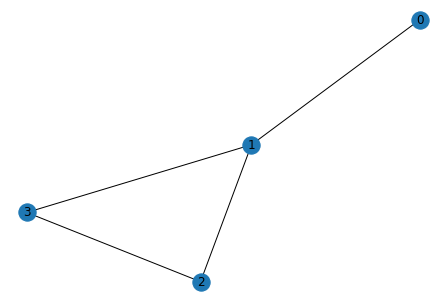

In [9]:
edge_index = torch.tensor([[0, 1, 2, 3, 1, 2, 3, 1],
                           [1, 2, 3, 1, 0, 1, 2, 3]], dtype=torch.long).to(DEVICE)
x = torch.tensor([[-1], [0], [1], [1]], dtype=torch.float).to(DEVICE)

data = Data(x=x, edge_index=edge_index)

g = torch_geometric.utils.to_networkx(data, to_undirected=True, node_attrs=['x'])
try:
  nx.draw(g, pos=nx.spring_layout(g),  with_labels = True)
except:
  pass

In [10]:
data = lift_nx_to_pyg(g)
data, data.x, data.edge_index

(Data(edge_index=[2, 24], x=[10, 1]),
 tensor([[0.],
         [1.],
         [0.],
         [3.],
         [0.],
         [3.],
         [0.],
         [1.],
         [1.],
         [1.]]),
 tensor([[0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 4, 4, 4, 5, 5, 6, 6, 6, 7, 7, 8, 8, 9, 9],
         [1, 3, 5, 0, 2, 1, 7, 8, 0, 4, 3, 7, 9, 0, 6, 5, 8, 9, 2, 4, 2, 6, 4, 6]]))

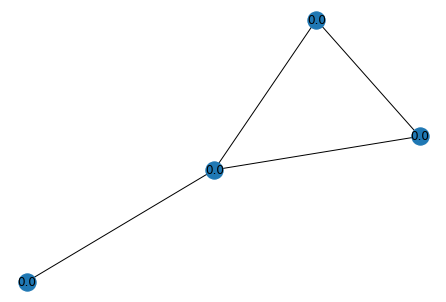

In [11]:
draw_pyg(data, filename='examplegraph.png')
if IN_COLAB:
  plt.show()

## Dataset

### d-Regular

In [12]:
class ShuffleList:
    def __init__(self, data):
        self.data = data
        self.index = 0

    def __iter__(self):
        random.shuffle(self.data)
        self.index = 0
        return self

    def __next__(self):
        if self.index < len(self.data):
            value = self.data[self.index]
            self.index += 1
            return value
        else:
            raise StopIteration

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

In [13]:
def build_dataset(num_nodes=NUM_NODES, num_samples=NUM_SAMPLES, degree=DEGREE, seed=1234):
  graph_dataset = list() 

  for _ in range(num_samples):
    while True:
      seed += 1
      graph = nx.random_regular_graph(d=degree, n=num_nodes, seed=seed)
      if nx.is_connected(graph):
        graph.x = torch.ones(num_nodes).t()
        graph_dataset.append(lift_nx_to_pyg(graph))
        break

  graph_dataset_train = graph_dataset[:int(len(graph_dataset)*0.8)]
  graph_dataset_test = graph_dataset[int(len(graph_dataset)*0.8):]
  return ShuffleList(graph_dataset_train), ShuffleList(graph_dataset_test)



In [14]:
#def build_test_set_nx(seed):
#  graph_dataset = build_dataset(num_samples=10, seed=seed)
#  graph_dataset_nx = list()
#  for i, g in enumerate(graph_dataset):
#    nx_orig_graph = draw_pyg(g, filename=f"test_graph_sample{str(i).zfill(5)}.jpg")
#    graph_dataset_nx.append(nx_orig_graph)
#  return graph_dataset_nx



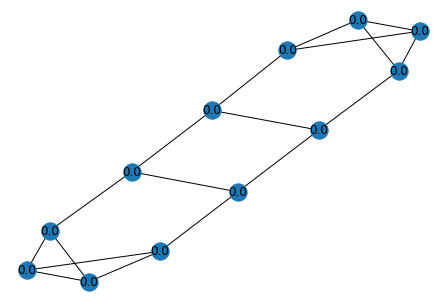

In [15]:
dataset, _  = build_dataset()
data = dataset[0]
draw_pyg(data)

In [16]:
dataset[0]

Data(edge_index=[2, 264], x=[78, 1])

In [17]:
# TODO dataloader
from torch_geometric.loader import DataLoader
train_loader = DataLoader(dataset, batch_size=10, shuffle=True)
for step, data in enumerate(train_loader):
  print(f'Step {step + 1}:')
  print('=======')
  print(f'Number of graphs in the current batch: {data.num_graphs}')
  print(data)
  print()
  print(data.x.flatten(), data.edge_index, data.batch)
  break


# for gen of training sample:
# 1) mask 0 ... (all -1) (inclusivly) 
# 2) swich exactly 1 of the unmasked

Step 1:
Number of graphs in the current batch: 10
DataBatch(edge_index=[2, 2640], x=[780, 1], batch=[780], ptr=[11])

tensor([0., 1., 0., 1., 0., 3., 0., 1., 0., 3., 0., 3., 0., 3., 0., 3., 0., 3.,
        0., 3., 0., 3., 0., 1., 3., 3., 3., 3., 3., 3., 3., 3., 1., 3., 3., 3.,
        3., 3., 3., 3., 1., 3., 3., 1., 3., 3., 3., 1., 1., 3., 1., 3., 3., 1.,
        3., 3., 3., 3., 3., 1., 3., 3., 3., 1., 3., 1., 3., 1., 1., 3., 3., 1.,
        3., 3., 3., 1., 3., 3., 0., 3., 0., 3., 0., 1., 0., 1., 0., 3., 0., 3.,
        0., 3., 0., 3., 0., 3., 0., 1., 0., 3., 0., 3., 3., 3., 3., 1., 3., 1.,
        3., 3., 1., 3., 3., 1., 1., 3., 3., 3., 3., 1., 3., 3., 3., 3., 1., 1.,
        3., 3., 3., 3., 1., 1., 3., 3., 3., 3., 3., 3., 1., 1., 3., 1., 3., 3.,
        3., 3., 3., 3., 3., 1., 3., 3., 3., 1., 3., 3., 0., 3., 0., 3., 0., 3.,
        0., 3., 0., 3., 0., 1., 0., 1., 0., 3., 0., 3., 0., 3., 0., 1., 0., 3.,
        3., 1., 1., 3., 3., 3., 3., 3., 1., 3., 3., 3., 3., 3., 1., 1., 3., 1.,
  

### Planar

In [18]:

from torch.utils.data import random_split, Dataset
import torch_geometric.utils

def load_dataset_planar():
  nx_set = list()
  num_nodes = 64
  graph_dataset = list() 
  if not os.path.exists("SPECTRE"):
    os.system("git clone https://github.com/KarolisMart/SPECTRE.git")
  adjs, eigvals, eigvecs, n_nodes, max_eigval, min_eigval, same_sample, n_max = torch.load('SPECTRE/data/planar_64_200.pt')
  for adj in adjs:
    # from adj matrix to nx
    graph = nx.from_numpy_array(adj.numpy())
    # from nx to pyg
    graph.x = torch.ones(num_nodes).t()
    graph_dataset.append(lift_nx_to_pyg(graph))

  #graph_dataset_train = graph_dataset[:int(len(graph_dataset)*0.8)]
  #graph_dataset_test = graph_dataset[int(len(graph_dataset)*0.8):]
  #return ShuffleList(graph_dataset_train), ShuffleList(graph_dataset_test)

  test_len = int(round(len(graph_dataset) * 0.2))
  train_len = int(round((len(graph_dataset) - test_len) * 0.8))
  val_len = len(graph_dataset) - train_len - test_len
  print(f'Dataset sizes: train {train_len}, val {val_len}, test {test_len}')
  splits = random_split(graph_dataset, [train_len, val_len, test_len], generator=torch.Generator().manual_seed(1234))
  datasets = {'train': splits[0], 'val': splits[1], 'test': splits[2]}
  return ShuffleList(list(datasets['train'])), ShuffleList(list(datasets['test']))


load_dataset_planar()  # get baseline by comparing 128 with 32

Dataset sizes: train 128, val 32, test 40


(<__main__.ShuffleList at 0x2a8cf9250>, <__main__.ShuffleList at 0x2a8cf9280>)

In [19]:
graph_dataset, _ = load_dataset_planar()

Dataset sizes: train 128, val 32, test 40


In [20]:
graph_dataset[0],graph_dataset[1]

(Data(edge_index=[2, 8064], x=[2080, 1]),
 Data(edge_index=[2, 8064], x=[2080, 1]))

In [21]:
#draw_pyg(graph_dataset[0])

### Block


In [22]:
def load_dataset_block():
  nx_set = list()
  num_nodes = 64
  graph_dataset = list() 
  if not os.path.exists("SPECTRE"):
    os.system("git clone https://github.com/KarolisMart/SPECTRE.git")
  adjs, eigvals, eigvecs, n_nodes, max_eigval, min_eigval, same_sample, n_max = torch.load('SPECTRE/data/sbm_200.pt')
  for adj in adjs:
    # from adj matrix to nx
    graph = nx.from_numpy_array(adj.numpy())
    print('number of nodes ', graph.number_of_nodes())
    # from nx to pyg
    graph.x = torch.ones(num_nodes).t()
    graph_dataset.append(lift_nx_to_pyg(graph))

  #graph_dataset_train = graph_dataset[:int(len(graph_dataset)*0.8)]
  #graph_dataset_test = graph_dataset[int(len(graph_dataset)*0.8):]
  #return ShuffleList(graph_dataset_train), ShuffleList(graph_dataset_test)

  test_len = int(round(len(graph_dataset) * 0.2))
  train_len = int(round((len(graph_dataset) - test_len) * 0.8))
  val_len = len(graph_dataset) - train_len - test_len
  print(f'Dataset sizes: train {train_len}, val {val_len}, test {test_len}')
  splits = random_split(graph_dataset, [train_len, val_len, test_len], generator=torch.Generator().manual_seed(1234))
  datasets = {'train': splits[0], 'val': splits[1], 'test': splits[2]}
  return ShuffleList(list(datasets['train'])), ShuffleList(list(datasets['test']))


load_dataset_block()

number of nodes  172
number of nodes  92
number of nodes  61
number of nodes  64
number of nodes  115
number of nodes  101
number of nodes  90
number of nodes  123
number of nodes  168
number of nodes  61
number of nodes  130
number of nodes  62
number of nodes  163
number of nodes  58
number of nodes  71
number of nodes  156
number of nodes  77
number of nodes  169
number of nodes  141
number of nodes  103
number of nodes  89
number of nodes  81
number of nodes  88
number of nodes  164
number of nodes  88
number of nodes  117
number of nodes  128
number of nodes  69
number of nodes  64
number of nodes  58
number of nodes  152
number of nodes  97
number of nodes  166
number of nodes  101
number of nodes  106
number of nodes  57
number of nodes  76
number of nodes  115
number of nodes  52
number of nodes  112
number of nodes  64
number of nodes  63
number of nodes  169
number of nodes  54
number of nodes  90
number of nodes  129
number of nodes  105
number of nodes  53
number of nodes  

(<__main__.ShuffleList at 0x2aabd8850>, <__main__.ShuffleList at 0x2a4db9b20>)

In [23]:
x,_ = load_dataset_block()
x

number of nodes  172
number of nodes  92
number of nodes  61
number of nodes  64
number of nodes  115
number of nodes  101
number of nodes  90
number of nodes  123
number of nodes  168
number of nodes  61
number of nodes  130
number of nodes  62
number of nodes  163
number of nodes  58
number of nodes  71
number of nodes  156
number of nodes  77
number of nodes  169
number of nodes  141
number of nodes  103
number of nodes  89
number of nodes  81
number of nodes  88
number of nodes  164
number of nodes  88
number of nodes  117
number of nodes  128
number of nodes  69
number of nodes  64
number of nodes  58
number of nodes  152
number of nodes  97
number of nodes  166
number of nodes  101
number of nodes  106
number of nodes  57
number of nodes  76
number of nodes  115
number of nodes  52
number of nodes  112
number of nodes  64
number of nodes  63
number of nodes  169
number of nodes  54
number of nodes  90
number of nodes  129
number of nodes  105
number of nodes  53
number of nodes  

In [24]:
x[0]

Data(edge_index=[2, 44104], x=[11175, 1])

## Loss & Stats

In [25]:
import pyemd
import numpy as np
import concurrent.futures
from functools import partial
from scipy.linalg import toeplitz

from datetime import datetime


PRINT_TIME = False

def degree_worker(G):
    return np.array(nx.degree_histogram(G))

def degree_stats(graph_ref_list, graph_pred_list, is_parallel=True, compute_emd=False):
    ''' Compute the distance between the degree distributions of two unordered sets of graphs.
        Args:
            graph_ref_list, graph_target_list: two lists of networkx graphs to be evaluated
        '''
    sample_ref = []
    sample_pred = []
    # in case an empty graph is generated
    graph_pred_list_remove_empty = [
        G for G in graph_pred_list if not G.number_of_nodes() == 0
    ]

    prev = datetime.now()
    if is_parallel:
        with concurrent.futures.ThreadPoolExecutor() as executor:
            for deg_hist in executor.map(degree_worker, graph_ref_list):
                sample_ref.append(deg_hist)
        with concurrent.futures.ThreadPoolExecutor() as executor:
            for deg_hist in executor.map(degree_worker, graph_pred_list_remove_empty):
                sample_pred.append(deg_hist)
    else:
        for i in range(len(graph_ref_list)):
            degree_temp = np.array(nx.degree_histogram(graph_ref_list[i]))
            sample_ref.append(degree_temp)
        for i in range(len(graph_pred_list_remove_empty)):
            degree_temp = np.array(
                nx.degree_histogram(graph_pred_list_remove_empty[i]))
            sample_pred.append(degree_temp)

    # mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=gaussian_emd)
    # mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=emd)
    if compute_emd:
        # EMD option uses the same computation as GraphRNN, the alternative is MMD as computed by GRAN
        # mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=emd)
        mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=gaussian_emd)
    else:
        mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=gaussian_tv)
    # mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=gaussian)

    elapsed = datetime.now() - prev
    if PRINT_TIME:
        print('Time computing degree mmd: ', elapsed)
    return mmd_dist



def clustering_worker(param):
    G, bins = param
    clustering_coeffs_list = list(nx.clustering(G).values())
    hist, _ = np.histogram(
        clustering_coeffs_list, bins=bins, range=(0.0, 1.0), density=False)
    return hist


def clustering_stats(graph_ref_list,
                     graph_pred_list,
                     bins=100,
                     is_parallel=True, compute_emd=False):
    sample_ref = []
    sample_pred = []
    graph_pred_list_remove_empty = [
        G for G in graph_pred_list if not G.number_of_nodes() == 0
    ]

    prev = datetime.now()
    if is_parallel:
        with concurrent.futures.ThreadPoolExecutor() as executor:
            for clustering_hist in executor.map(clustering_worker,
                                                [(G, bins) for G in graph_ref_list]):
                sample_ref.append(clustering_hist)
        with concurrent.futures.ThreadPoolExecutor() as executor:
            for clustering_hist in executor.map(
                    clustering_worker, [(G, bins) for G in graph_pred_list_remove_empty]):
                sample_pred.append(clustering_hist)

        # check non-zero elements in hist
        # total = 0
        # for i in range(len(sample_pred)):
        #    nz = np.nonzero(sample_pred[i])[0].shape[0]
        #    total += nz
        # print(total)
    else:
        for i in range(len(graph_ref_list)):
            clustering_coeffs_list = list(nx.clustering(graph_ref_list[i]).values())
            hist, _ = np.histogram(
                clustering_coeffs_list, bins=bins, range=(0.0, 1.0), density=False)
            sample_ref.append(hist)

        for i in range(len(graph_pred_list_remove_empty)):
            clustering_coeffs_list = list(
                nx.clustering(graph_pred_list_remove_empty[i]).values())
            hist, _ = np.histogram(
                clustering_coeffs_list, bins=bins, range=(0.0, 1.0), density=False)
            sample_pred.append(hist)

    if compute_emd:
        # EMD option uses the same computation as GraphRNN, the alternative is MMD as computed by GRAN
        # mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=emd, sigma=1.0 / 10)
        mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=gaussian_emd, sigma=1.0 / 10, distance_scaling=bins)
    else:
        mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=gaussian_tv, sigma=1.0 / 10)

    elapsed = datetime.now() - prev
    if PRINT_TIME:
        print('Time computing clustering mmd: ', elapsed)
    return mmd_dist



# maps motif/orbit name string to its corresponding list of indices from orca output
motif_to_indices = {
    '3path': [1, 2],
    '4cycle': [8],
}
COUNT_START_STR = 'orbit counts:'


def edge_list_reindexed(G):
    idx = 0
    id2idx = dict()
    for u in G.nodes():
        id2idx[str(u)] = idx
        idx += 1

    edges = []
    for (u, v) in G.edges():
        edges.append((id2idx[str(u)], id2idx[str(v)]))
    return edges

def orca(graph):
    # tmp_fname = f'analysis/orca/tmp_{"".join(secrets.choice(ascii_uppercase + digits) for i in range(8))}.txt'
    tmp_fname = f'orca/tmp_{"".join(secrets.choice(ascii_uppercase + digits) for i in range(8))}.txt'
    tmp_fname = os.path.join(os.path.dirname(os.path.realpath(__file__)), tmp_fname)
    # print(tmp_fname, flush=True)
    f = open(tmp_fname, 'w')
    f.write(
        str(graph.number_of_nodes()) + ' ' + str(graph.number_of_edges()) + '\n')
    for (u, v) in edge_list_reindexed(graph):
        f.write(str(u) + ' ' + str(v) + '\n')
    f.close()
    output = sp.check_output(
        [str(os.path.join(os.path.dirname(os.path.realpath(__file__)), 'orca/orca')), 'node', '4', tmp_fname, 'std'])
    output = output.decode('utf8').strip()
    idx = output.find(COUNT_START_STR) + len(COUNT_START_STR) + 2
    output = output[idx:]
    node_orbit_counts = np.array([
        list(map(int,
                 node_cnts.strip().split(' ')))
        for node_cnts in output.strip('\n').split('\n')
    ])

    try:
        os.remove(tmp_fname)
    except OSError:
        pass

    return node_orbit_counts


def orbit_stats_all(graph_ref_list, graph_pred_list, compute_emd=False):
    total_counts_ref = []
    total_counts_pred = []

    graph_pred_list_remove_empty = [
        G for G in graph_pred_list if not G.number_of_nodes() == 0
    ]

    for G in graph_ref_list:
        orbit_counts = orca(G)
        orbit_counts_graph = np.sum(orbit_counts, axis=0) / G.number_of_nodes()
        total_counts_ref.append(orbit_counts_graph)

    for G in graph_pred_list:
        orbit_counts = orca(G)
        orbit_counts_graph = np.sum(orbit_counts, axis=0) / G.number_of_nodes()
        total_counts_pred.append(orbit_counts_graph)

    total_counts_ref = np.array(total_counts_ref)
    total_counts_pred = np.array(total_counts_pred)

    # mmd_dist = compute_mmd(
    #     total_counts_ref,
    #     total_counts_pred,
    #     kernel=gaussian,
    #     is_hist=False,
    #     sigma=30.0)

    # mmd_dist = compute_mmd(
    #         total_counts_ref,
    #         total_counts_pred,
    #         kernel=gaussian_tv,
    #         is_hist=False,
    #         sigma=30.0)  

    if compute_emd:
        # mmd_dist = compute_mmd(total_counts_ref, total_counts_pred, kernel=emd, sigma=30.0)
        # EMD option uses the same computation as GraphRNN, the alternative is MMD as computed by GRAN
        mmd_dist = compute_mmd(total_counts_ref, total_counts_pred, kernel=gaussian, is_hist=False, sigma=30.0)
    else:
        mmd_dist = compute_mmd(total_counts_ref, total_counts_pred, kernel=gaussian_tv, is_hist=False, sigma=30.0)
    return mmd_dist




def gaussian(x, y, sigma=1.0):
    support_size = max(len(x), len(y))
    # convert histogram values x and y to float, and make them equal len
    x = x.astype(float)
    y = y.astype(float)
    if len(x) < len(y):
        x = np.hstack((x, [0.0] * (support_size - len(x))))
    elif len(y) < len(x):
        y = np.hstack((y, [0.0] * (support_size - len(y))))

    dist = np.linalg.norm(x - y, 2)
    return np.exp(-dist * dist / (2 * sigma * sigma))


def gaussian_tv(x, y, sigma=1.0):  
    support_size = max(len(x), len(y))
    # convert histogram values x and y to float, and make them equal len
    x = x.astype(float)
    y = y.astype(float)
    if len(x) < len(y):
        x = np.hstack((x, [0.0] * (support_size - len(x))))
    elif len(y) < len(x):
        y = np.hstack((y, [0.0] * (support_size - len(y))))

    dist = np.abs(x - y).sum() / 2.0
    return np.exp(-dist * dist / (2 * sigma * sigma))


def kernel_parallel_unpacked(x, samples2, kernel):
    d = 0
    for s2 in samples2:
        d += kernel(x, s2)
    return d


def kernel_parallel_worker(t):
    return kernel_parallel_unpacked(*t)




def disc(samples1, samples2, kernel, is_parallel=True, *args, **kwargs):
    ''' Discrepancy between 2 samples '''
    d = 0

    if not is_parallel:
        for s1 in samples1:
            for s2 in samples2:
                d += kernel(s1, s2, *args, **kwargs)
    else:
        with concurrent.futures.ThreadPoolExecutor() as executor:
            for dist in executor.map(kernel_parallel_worker, [
                    (s1, samples2, partial(kernel, *args, **kwargs)) for s1 in samples1
            ]):
                d += dist
    if len(samples1) * len(samples2) > 0:
        d /= len(samples1) * len(samples2)
    else:
        d = 1e+6
    #print('error')
    return d


def compute_mmd(samples1, samples2, kernel, is_hist=True, *args, **kwargs):
    ''' MMD between two samples '''
    # normalize histograms into pmf
    if is_hist:
        samples1 = [s1 / (np.sum(s1) + 1e-6) for s1 in samples1]
        samples2 = [s2 / (np.sum(s2) + 1e-6) for s2 in samples2]
    #print(samples1)
    return disc(samples1, samples1, kernel, *args, **kwargs) + disc(samples2, samples2, kernel, *args, **kwargs) - \
                2 * disc(samples1, samples2, kernel, *args, **kwargs)


def compute_emd(samples1, samples2, kernel, is_hist=True, *args, **kwargs):
    ''' EMD between average of two samples '''
    # normalize histograms into pmf
    if is_hist:
        samples1 = [np.mean(samples1)]
        samples2 = [np.mean(samples2)]
    return disc(samples1, samples2, kernel, *args,
                            **kwargs), [samples1[0], samples2[0]]



def compute_mmd_stats(graphs_ref_nx, graphs_pred_nx):
  if 'networkx' not in str(type(graphs_ref_nx[0])):
    graphs_ref_nx = [pyg_graph_to_nx(g) for g in graphs_ref_nx]
  if 'networkx' not in str(type(graphs_pred_nx[0])):
    graphs_pred_nx = [pyg_graph_to_nx(g) for g in graphs_pred_nx]
  return degree_stats(graphs_ref_nx, graphs_pred_nx), clustering_stats(graphs_ref_nx, graphs_pred_nx)


def compute_expected_optimal_loss(graph_dataset_train, graph_dataset_test):
  graph_dataset_train_nx = [pyg_graph_to_nx(g) for g in graph_dataset_train]
  graph_dataset_test_nx = [pyg_graph_to_nx(g) for g in graph_dataset_test]
  return compute_mmd_stats(graph_dataset_train_nx, graph_dataset_test_nx)

#def compute_expected_optimal_loss(graphs_ref_nx):
#  graphs_ref_nx2 = build_test_set_nx(1337)
#  return compute_mmd_stats(graphs_ref_nx, graphs_ref_nx2)

## Model

#### AttentionNet

In [26]:
from torch_geometric.nn import GATv2Conv, GraphNorm, BatchNorm

class AttentionNet(torch.nn.Module):
  def __init__(self, hidden_dim=32, layer_num=6, dropout=0.1, normalization=False, single_pass_pooling=False):
    super(AttentionNet, self).__init__()

    self.mlp_list = nn.ModuleList()
    self.conv_list = nn.ModuleList()
    self.sigmoid = nn.Sigmoid()
    self.dropout = dropout
    self.graph_norms = nn.ModuleList()
    self.normalization = normalization
    self.single_pass_pooling = single_pass_pooling
    assert(hidden_dim % 2 == 0)
    input_channels = NUM_CLASSES

    for i in range(layer_num):
      in_dim = hidden_dim if i > 0 else input_channels 
      out_dim = hidden_dim if i < layer_num-1 else 1 
      self.conv_list.append(GATv2Conv(in_channels=in_dim, out_channels=hidden_dim // 2, heads=2))
      self.graph_norms.append(BatchNorm(hidden_dim))
      self.mlp_list.append(Seq(Lin(hidden_dim, hidden_dim), nn.ReLU(), Lin(hidden_dim, hidden_dim), nn.ReLU(), Lin(hidden_dim, out_dim)))

  def forward(self, x_in, edge_index, batch):
    x = note_features_to_one_hot(x_in)
    for i in range(len(self.conv_list)):
      x = self.conv_list[i](x, edge_index)
      x = F.relu(x)
      if self.normalization:
        x = self.graph_norms[i](x)
      x = self.mlp_list[i](x)
      #if i == 0:
      #  x = self.dropout(x)

    if self.single_pass_pooling:
      x = global_mask_pool(x, x_in, batch)
    else:
      x = global_mean_pool(x, batch)
    x = F.dropout(x, p=self.dropout, training=self.training)
    x = self.sigmoid(x) + EPSILON
    return x.flatten()


In [27]:
model = AttentionNet(single_pass_pooling=True)
model.to(DEVICE)
print(model) 
for step, data in enumerate(train_loader):
  data = data.to(DEVICE)
  print(model(data.x, data.edge_index, data.batch))
  break

AttentionNet(
  (mlp_list): ModuleList(
    (0-4): 5 x Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=32, bias=True)
    )
    (5): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (conv_list): ModuleList(
    (0): GATv2Conv(4, 16, heads=2)
    (1-5): 5 x GATv2Conv(32, 16, heads=2)
  )
  (sigmoid): Sigmoid()
  (graph_norms): ModuleList(
    (0-5): 6 x BatchNorm(32)
  )
)
tensor([0.5210, 0.5210, 0.5210, 0.5210, 0.5210, 0.5210, 0.5210, 0.5210, 0.5210,
        0.5000], grad_fn=<ReshapeAliasBackward0>)


#### TransformerNet

In [28]:
#relu = nn.Relu() ## todo: changed to relu here
from torch_geometric.nn import TransformerConv

class TransformerNet(torch.nn.Module):
  def __init__(self, hidden_dim=32, layer_num=6, dropout=0.1, normalization=False, single_pass_pooling = False):
    super(TransformerNet, self).__init__()

    self.mlp_list = nn.ModuleList()
    self.conv_list = nn.ModuleList()
    self.sigmoid = nn.Sigmoid()
    self.graph_norms = nn.ModuleList()
    self.dropout = dropout
    self.normalization = normalization
    assert(hidden_dim % 2 == 0)
    input_channels = NUM_CLASSES
    self.single_pass_pooling = single_pass_pooling


    for i in range(layer_num):
      in_dim = hidden_dim if i > 0 else input_channels 
      out_dim = hidden_dim if i < layer_num-1 else 1 
      self.conv_list.append(TransformerConv(in_channels=in_dim, out_channels=hidden_dim // 2, heads=2))
      self.graph_norms.append(BatchNorm(hidden_dim))
      self.mlp_list.append(Seq(Lin(hidden_dim, hidden_dim), nn.ReLU(), Lin(hidden_dim, hidden_dim), nn.ReLU(), Lin(hidden_dim, out_dim)))

  def forward(self, x_in, edge_index, batch):
    x = note_features_to_one_hot(x_in)
    for i in range(len(self.conv_list)):
      x = self.conv_list[i](x, edge_index)
      if self.normalization:
        x = self.graph_norms[i](x)
      x = F.dropout(x, p=self.dropout, training=self.training)
      x = self.mlp_list[i](x)
    
    if self.single_pass_pooling:
      x = global_mask_pool(x, x_in, batch)
    else:
      x = global_mean_pool(x, batch)

    x = self.sigmoid(x) + EPSILON
    return x.flatten()


In [29]:
model = TransformerNet()
model.to(DEVICE)
print(model) 
for step, data in enumerate(train_loader):
  data = data.to(DEVICE)
  print(model(data.x, data.edge_index, data.batch))
  break

TransformerNet(
  (mlp_list): ModuleList(
    (0-4): 5 x Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=32, bias=True)
    )
    (5): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (conv_list): ModuleList(
    (0): TransformerConv(4, 16, heads=2)
    (1-5): 5 x TransformerConv(32, 16, heads=2)
  )
  (sigmoid): Sigmoid()
  (graph_norms): ModuleList(
    (0-5): 6 x BatchNorm(32)
  )
)
tensor([0.4885, 0.4883, 0.4884, 0.4885, 0.4884, 0.4884, 0.4883, 0.4883, 0.4884,
        0.4884], grad_fn=<ReshapeAliasBackward0>)


#### Unet

In [30]:
from torch_geometric.nn import GraphUNet

class Unet(torch.nn.Module):
  def __init__(self, hidden_channels=32, out_channels=1, depth=4, single_pass_pooling = False):
    super(Unet, self).__init__()
    self.sigmoid = nn.Sigmoid()
    in_channels = NUM_CLASSES
    self.single_pass_pooling = single_pass_pooling
    self.unet = GraphUNet(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=out_channels, depth=depth)

  def forward(self, x_in, edge_index, batch):
    x = note_features_to_one_hot(x_in)
    x = self.unet(x, edge_index)

    if self.single_pass_pooling:
      x = global_mask_pool(x, x_in, batch)
    else:
      x = global_mean_pool(x, batch)

    x = self.sigmoid(x) + 0.0000001 # add eps to avoid div. by zero
    return x.flatten()
  

In [31]:

model = Unet()
model.to(DEVICE)
print(model) 
for step, data in enumerate(train_loader):
  data.to(DEVICE)
  print(model(data.x, data.edge_index, data.batch))
  break

Unet(
  (sigmoid): Sigmoid()
  (unet): GraphUNet(4, 32, 1, depth=4, pool_ratios=[0.5, 0.5, 0.5, 0.5])
)
tensor([0.5508, 0.5508, 0.5508, 0.5508, 0.5508, 0.5502, 0.5505, 0.5508, 0.5506,
        0.5507], grad_fn=<ReshapeAliasBackward0>)


/Users/gerritgrossmann/anaconda3/envs/nextaid/lib/python3.9/site-packages/torch_sparse/matmul.py:97: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343673238/work/aten/src/ATen/SparseCsrTensorImpl.cpp:56.)
  C = torch.sparse.mm(A, B)


#### PNA

In [32]:
def print_inputs(*args):
    for arg in args:
        print(arg)


In [33]:
from torch_geometric.nn import PNA
from torch_geometric.utils import degree

#train_dataset = build_dataset()

def dataset_to_degree_bin(train_dataset):
  # Compute the maximum in-degree in the training data.
  max_degree = -1
  for data in train_dataset:
      d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
      max_degree = max(max_degree, int(d.max()))

  deg = torch.zeros(max_degree + 1, dtype=torch.long)
  for data in train_dataset:
      d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
      deg += torch.bincount(d, minlength=deg.numel())
  return deg

class PNAnet(torch.nn.Module):
  def __init__(self, train_dataset_example, hidden_channels=32, depth=4, dropout=0.0, towers=2, single_pass_pooling=False, graph_transform=False, normalization=True, pre_post_layers=1):
    super(PNAnet, self).__init__()
    self.sigmoid = nn.Sigmoid()

    # Calculate x as the difference between mult_y and hidden_dim
    hidden_channels = towers * ((hidden_channels // towers) + 1)
    #out_channels = towers * ((out_channels // towers) + 1)

    in_channels = NUM_CLASSES
    if graph_transform:
      in_channels += NODE_FEATURE_EXTEND
    deg = dataset_to_degree_bin(train_dataset_example)
    aggregators = ['mean', 'min', 'max', 'std']
    scalers = ['identity', 'amplification', 'attenuation']
    self.normalization = BatchNorm(hidden_channels) if normalization else None
    self.pnanet = PNA(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=hidden_channels, num_layers=depth, aggregators=aggregators, scalers=scalers, deg=deg, dropout=dropout, towers=towers, norm=self.normalization, pre_layers=pre_post_layers, post_layers=pre_post_layers)
    self.single_pass_pooling = single_pass_pooling
    self.graph_transform = graph_transform

    self.final_mlp = Seq(Lin(hidden_channels, hidden_channels), nn.ReLU(), Lin(hidden_channels, hidden_channels), nn.ReLU(), Lin(hidden_channels, 1))


  def forward(self, x_in, edge_index, batch):
    x = note_features_to_one_hot(x_in)
    if self.graph_transform:
      x = extend_node_features(x, edge_index, batch)
    x = self.pnanet(x, edge_index)

    if self.single_pass_pooling:
      x = global_mask_pool(x, x_in, batch)
    else:
      x = global_mean_pool(x, batch)

    #x = x.sum(dim=1)
    x = self.final_mlp(x)
    x = self.sigmoid(x) + EPSILON # add eps to avoid div. by zero
    return x.flatten()

class PNAmulti(torch.nn.Module):
  def __init__(self, train_dataset_example, hidden_channels=32, graph_transform=False, depth=4, dropout=0.0, towers=1, model_num=5, single_pass_pooling=False, normalization=True, pre_post_layers=1):
    super(PNAmulti, self).__init__()
    self.model_num = model_num
    self.pna_list = nn.ModuleList()
    self.sigmoid = nn.Sigmoid()
    weights = torch.ones(model_num)
    self.weights = nn.Parameter(weights)  # nn.Parameter is a Tensor that's a module parameter.
    for i in range(model_num):
      # towers is i+1
      pna_model = PNAnet(train_dataset_example, hidden_channels=hidden_channels, graph_transform=graph_transform, depth=depth, dropout=dropout, towers=i+1, single_pass_pooling=single_pass_pooling, normalization=normalization, pre_post_layers=pre_post_layers)
      self.pna_list.append(pna_model)

  def get_normalized_weights(self):
    w_sigmoid = self.sigmoid(self.weights)
    w = w_sigmoid/w_sigmoid.sum()
    return w

  def forward(self, x, edge_index, batch):
    x_agg = None
    i_not = random.choice(range(len(self.pna_list))) if self.training  and len(self.pna_list) > 1 else -1 # skip 1 during training
    w = self.get_normalized_weights()
    for i, pna_model in enumerate(self.pna_list):
      if i == i_not:
        continue
      if x_agg is None:
        x_agg = pna_model(x, edge_index, batch) * w[i]
      else:
        x_agg = x_agg + pna_model( x, edge_index, batch) * w[i]
    return x_agg


In [34]:
model = PNAmulti(build_dataset()[0])
model.to(DEVICE)
print(model) 
for step, data in enumerate(train_loader):
  data.to(DEVICE)
  print(model(data.x, data.edge_index, data.batch))
  break

PNAmulti(
  (pna_list): ModuleList(
    (0): PNAnet(
      (sigmoid): Sigmoid()
      (normalization): BatchNorm(33)
      (pnanet): PNA(4, 33, num_layers=4)
      (final_mlp): Sequential(
        (0): Linear(in_features=33, out_features=33, bias=True)
        (1): ReLU()
        (2): Linear(in_features=33, out_features=33, bias=True)
        (3): ReLU()
        (4): Linear(in_features=33, out_features=1, bias=True)
      )
    )
    (1): PNAnet(
      (sigmoid): Sigmoid()
      (normalization): BatchNorm(34)
      (pnanet): PNA(4, 34, num_layers=4)
      (final_mlp): Sequential(
        (0): Linear(in_features=34, out_features=34, bias=True)
        (1): ReLU()
        (2): Linear(in_features=34, out_features=34, bias=True)
        (3): ReLU()
        (4): Linear(in_features=34, out_features=1, bias=True)
      )
    )
    (2): PNAnet(
      (sigmoid): Sigmoid()
      (normalization): BatchNorm(33)
      (pnanet): PNA(4, 33, num_layers=4)
      (final_mlp): Sequential(
        (0): Li

In [35]:
model = PNAnet(build_dataset()[0])
model.to(DEVICE)
print(model) 
for step, data in enumerate(train_loader):
  data.to(DEVICE)
  print(model(data.x, data.edge_index, data.batch))
  break

PNAnet(
  (sigmoid): Sigmoid()
  (normalization): BatchNorm(34)
  (pnanet): PNA(4, 34, num_layers=4)
  (final_mlp): Sequential(
    (0): Linear(in_features=34, out_features=34, bias=True)
    (1): ReLU()
    (2): Linear(in_features=34, out_features=34, bias=True)
    (3): ReLU()
    (4): Linear(in_features=34, out_features=1, bias=True)
  )
)
tensor([0.5186, 0.5186, 0.5186, 0.5186, 0.5186, 0.5186, 0.5186, 0.5186, 0.5186,
        0.5186], grad_fn=<ReshapeAliasBackward0>)


#### PNA2

In [36]:
from torch_geometric.nn import PNAConv

class PNA2net(torch.nn.Module):
  def __init__(self, train_dataset_example, hidden_dim=32, layer_num=4, dropout=0.0, normalization=False, tower_num=5, single_pass_pooling=False):
    super().__init__()

    aggregators = ['mean', 'min', 'max', 'std', 'var', 'sum']
    scalers = ['identity', 'amplification', 'attenuation']
    deg = dataset_to_degree_bin(train_dataset_example)

    # Calculate x as the difference between mult_y and hidden_dim
    hidden_dim = tower_num * ((hidden_dim // tower_num) + 1)

    self.conv_list = nn.ModuleList()
    self.batchnorm_list = nn.ModuleList()
    self.mlp_list = nn.ModuleList()

    self.dropout = dropout
    self.normalization = normalization
    self.sigmoid = nn.Sigmoid()
    self.single_pass_pooling = single_pass_pooling

    input_channels = NUM_CLASSES
  

    for i in range(layer_num):
      in_dim = hidden_dim if i > 0 else input_channels 
      out_dim = hidden_dim if i < layer_num-1 else 1 
      self.conv_list.append(PNAConv(in_channels=in_dim, out_channels=hidden_dim, aggregators=aggregators, scalers=scalers, deg=deg, towers=tower_num, pre_layers=1, post_layers=1, divide_input=False))
      self.batchnorm_list.append(BatchNorm(hidden_dim))
      self.mlp_list.append(Seq(nn.ReLU(), Lin(hidden_dim+NUM_CLASSES+in_dim, hidden_dim+NUM_CLASSES+in_dim), nn.ReLU(), Lin(hidden_dim+NUM_CLASSES+in_dim, hidden_dim+NUM_CLASSES+in_dim), nn.ReLU(), Lin(hidden_dim+NUM_CLASSES+in_dim, out_dim)))
          
  def forward(self, x_in, edge_index, batch):
    x_onehot = note_features_to_one_hot(x_in)
    x = x_onehot.clone()
    for i in range(len(self.conv_list)):
      x_in = x.clone()
      x = self.conv_list[i](x, edge_index)
      if self.normalization:
        x = self.batchnorm_list[i](x)
      x_concat = torch.concat([x, x_onehot, x_in], dim=1)
      x = self.mlp_list[i](x_concat)
      if i < len(self.conv_list)-1:
        x = F.dropout(x, p=self.dropout, training=self.training)

    if self.single_pass_pooling:
      x = global_mask_pool(x, x_in, batch)
    else:
      x = global_mean_pool(x, batch)
      
    x = self.sigmoid(x) + EPSILON
    return x.flatten()




In [37]:
model = PNA2net(build_dataset()[0])
model.to(DEVICE)
print(model) 
for step, data in enumerate(train_loader):
  data.to(DEVICE)
  print(model(data.x, data.edge_index, data.batch))
  break

PNA2net(
  (conv_list): ModuleList(
    (0): PNAConv(4, 35, towers=5, edge_dim=None)
    (1-3): 3 x PNAConv(35, 35, towers=5, edge_dim=None)
  )
  (batchnorm_list): ModuleList(
    (0-3): 4 x BatchNorm(35)
  )
  (mlp_list): ModuleList(
    (0): Sequential(
      (0): ReLU()
      (1): Linear(in_features=43, out_features=43, bias=True)
      (2): ReLU()
      (3): Linear(in_features=43, out_features=43, bias=True)
      (4): ReLU()
      (5): Linear(in_features=43, out_features=35, bias=True)
    )
    (1-2): 2 x Sequential(
      (0): ReLU()
      (1): Linear(in_features=74, out_features=74, bias=True)
      (2): ReLU()
      (3): Linear(in_features=74, out_features=74, bias=True)
      (4): ReLU()
      (5): Linear(in_features=74, out_features=35, bias=True)
    )
    (3): Sequential(
      (0): ReLU()
      (1): Linear(in_features=74, out_features=74, bias=True)
      (2): ReLU()
      (3): Linear(in_features=74, out_features=74, bias=True)
      (4): ReLU()
      (5): Linear(in_feat

### Build Model

In [38]:
def build_model(config, dataset):
  hidden_dim = config.hidden_dim
  single_pass_pooling = config.single_pass
  if config.model == "unet":
    model =  Unet(hidden_channels = hidden_dim,  out_channels = 1, depth=config.hidden_layer, single_pass_pooling=single_pass_pooling)
  elif config.model == "attention":
     model = AttentionNet(hidden_dim=hidden_dim, layer_num=config.hidden_layer, dropout=config.dropout, normalization=config.normalization, single_pass_pooling=single_pass_pooling)
  elif config.model == "transformer":
    model = TransformerNet(hidden_dim=hidden_dim, layer_num=config.hidden_layer, dropout=config.dropout, normalization=config.normalization, single_pass_pooling=single_pass_pooling)
  elif config.model == "pna":
    model = PNAnet(dataset, hidden_channels=hidden_dim, depth=config.hidden_layer, dropout=config.dropout, towers=config.towers, single_pass_pooling=single_pass_pooling, graph_transform=config.graph_transform, normalization=config.normalization, pre_post_layers=config.pre_post_layers)
  elif config.model == "pnamulti":
    model = PNAmulti(dataset, hidden_channels=hidden_dim, depth=config.hidden_layer, dropout=config.dropout, towers=config.towers, single_pass_pooling=single_pass_pooling, graph_transform=config.graph_transform, normalization=config.normalization, pre_post_layers=config.pre_post_layers)
  elif config.model == "pna2":
    model = PNA2net(dataset, hidden_dim=hidden_dim, layer_num=config.hidden_layer, dropout=config.dropout, normalization=config.normalization, single_pass_pooling=single_pass_pooling)
  else:
    ValueError("illegal net")
  return model.to(DEVICE)

## Inference

In [39]:
def find_best_choice(model, g, test_choices, x, x_shape):
  p_0_list = list()
  p_1_list = list()
  x_noedge_list = list()
  x_edge_list = list()
  mask_indicator_list = list()

  for i, mask_indicator in enumerate(test_choices):
    x_noedge, x_edge = x.clone(), x.clone()
    x_noedge[mask_indicator] = NO_EDGE_INDICATOR
    x_edge[mask_indicator] = EDGE_INDICATOR
    batch = torch.zeros(x_shape[0], dtype=torch.long).to(DEVICE)
    p_0 = model(x_noedge.view(x_shape), g.edge_index, batch=batch).item()
    p_1 = model(x_edge.view(x_shape), g.edge_index, batch=batch).item()

    p_0_list.append(p_0/(p_0+p_1))
    p_1_list.append(p_1/(p_0+p_1))
    x_noedge_list.append(x_noedge)
    x_edge_list.append(x_edge)
    mask_indicator_list.append(mask_indicator)

  best_i = np.argmax(p_1_list)
  return p_0_list[best_i], p_1_list[best_i], x_noedge_list[best_i],  x_edge_list[best_i], mask_indicator_list[best_i]


def generate_graph_multi(model, g, choice_num=5):
  x = g.x
  x_shape = x.shape
  x = x.flatten()
  indices_of_edges = (x != DUMMY).nonzero(as_tuple=False).flatten()
  num_edges = indices_of_edges.numel()
  x[indices_of_edges] = MASK
  indices_of_edges = indices_of_edges.flatten().tolist()

  for _ in range(num_edges):
    random.shuffle(indices_of_edges)
    choice_num_i = min(choice_num, len(indices_of_edges)) 
    test_choices = indices_of_edges[0:choice_num_i]
    p_0, p_1, x_noedge, x_edge, mask_indicator = find_best_choice(model, g, test_choices, x, x_shape)
    random_selection_index = int(np.random.choice([0, 1], size=1, p=[p_0, p_1]))
    x = (x_noedge, x_edge)[random_selection_index]
    indices_of_edges.remove(mask_indicator)

  g.x = x.reshape(x_shape)
  return g

In [40]:
def test_candidates(candidates, x, g, batch, x_shape):
  best_edge_index = None
  best_edge_prob = None

  for edge_index in candidates:
    x[edge_index] = -1.0
    edge_prob = model(x.view(x_shape), g.edge_index, batch=batch).item()
    x[edge_index] = MASK
    if best_edge_prob is None or max(edge_prob, 1.0-edge_prob) > best_edge_prob:
      best_edge_index = edge_index
      best_edge_prob = edge_prob

  return best_edge_index, best_edge_prob

def generate_graph_singlepass(model, g, choice_num = 1, config = None):
  # does not have multi
  x = g.x
  x_shape = x.shape
  x = x.flatten()
  indices_of_edges = (x != DUMMY).nonzero(as_tuple=False).flatten()
  num_edges = indices_of_edges.numel()
  x[indices_of_edges] = MASK
  indices_of_edges = indices_of_edges.flatten().tolist()
  random.shuffle(indices_of_edges)
  batch = torch.zeros(x_shape[0], dtype=torch.long).to(DEVICE)

  if config is not None and config.double_inference == True:
    indices_of_edges = list(indices_of_edges) + list(indices_of_edges)

  for i in range(len(indices_of_edges)):  
    i_dyn = min(choice_num, len(indices_of_edges) - i)
    candidates = indices_of_edges[i:i+i_dyn]
    #print("candidates ",candidates)
    edge_index, edge_prob = test_candidates(candidates, x, g, batch, x_shape)

    assert(edge_prob > 0.0 and edge_prob < 1.0)
    if random.random() < edge_prob:
      x[edge_index] = EDGE_INDICATOR
    else:
      x[edge_index] = NO_EDGE_INDICATOR

  g.x = x.reshape(x_shape)
  return g


In [41]:
@torch.inference_mode()
def generate_graphs(num, epoch_i, model, g_like, config):
  model.eval()
  mean_degree_list = list()
  var_degree_list = list()
  nx_graph_list = list()
  for j in range(num):
    if config.single_pass:
      g = generate_graph_singlepass(model, g_like, choice_num = config.candidate_selection_radius, config=config)
    else:
      g = generate_graph_multi(model, g_like, choice_num = config.candidate_selection_radius)
    nx_orig_graph = draw_pyg(g, filename=f"generated_graph_epoch{str(epoch_i).zfill(5)}_sample{str(j).zfill(5)}.jpg")
    degree_list = [nx_orig_graph.degree(i) for i in nx_orig_graph.nodes()]
    mean_degree_list.append(np.mean(degree_list))
    var_degree_list.append(np.var(degree_list))
    nx_graph_list.append(nx_orig_graph)
  return np.mean(mean_degree_list), np.mean(var_degree_list), nx_graph_list

## Generat Samples for Training

In [42]:
def gen_random_training_sample_unused(x):
  x_masked = x.clone().reshape(-1)
  indices_of_edges = (x_masked != DUMMY).nonzero(as_tuple=False).flatten()
  num_edges = indices_of_edges.numel()
  num_masked = torch.randint(1, num_edges+1, size=(1,), device=DEVICE)
  #num_masked = sample_num_masked_geometric(1, num_edges+1)

  shuffled_indices_of_edges = indices_of_edges[torch.randperm(indices_of_edges.numel())]
  indices_of_edges_to_mask = shuffled_indices_of_edges[:num_masked]
  
  gt_value = x_masked[indices_of_edges_to_mask[0]].item() # we will change the first value back
  x_masked[indices_of_edges_to_mask] = MASK


  x_masked_0 = x_masked.clone()
  x_masked_0[indices_of_edges_to_mask[0]] = NO_EDGE_INDICATOR
  x_masked_0 = x_masked_0.reshape(x.shape)

  x_masked_1 = x_masked.clone()
  x_masked_1[indices_of_edges_to_mask[0]] = EDGE_INDICATOR
  x_masked_1 = x_masked_1.reshape(x.shape)

  if gt_value == NO_EDGE_INDICATOR:
    return x_masked_0, x_masked_1
  elif gt_value == EDGE_INDICATOR:
    return x_masked_1, x_masked_0 
  assert(False)

  return None

In [43]:
def sample_mask_and_flip(batch, x):
  num_graphs = batch.view(-1)[-1]
  x_id_mask = list()
  x_id_flip = list()

  for graph_id in range(num_graphs+1):
    #num_nodes = (batch == graph_id).sum()
    #indices_of_edges = (x != DUMMY and batch == graph_id).nonzero(as_tuple=False)
    edge_indicator = x.view(-1) != DUMMY
    batch_indicator = batch.view(-1) == graph_id 
    indices_of_edges = torch.nonzero(batch_indicator & edge_indicator)
    indices_of_edges = indices_of_edges.flatten().tolist()
    random.shuffle(indices_of_edges)
    x_id_flip.append(indices_of_edges[-1])
    num_masked = random.choice(range(len(indices_of_edges)))
    x_id_mask = x_id_mask + indices_of_edges[:num_masked]

  mask_and_flip_indicator = torch.zeros(batch.numel(), dtype=torch.long).to(DEVICE)
  mask_and_flip_indicator[x_id_mask] = 1
  mask_and_flip_indicator[x_id_flip] = 2

  return mask_and_flip_indicator

def mask_x_based_on_indicator(x, mask_and_flip_indicator):
  x_new = x.clone()
  to_mask = mask_and_flip_indicator == 1
  x_new.view(-1)[to_mask] = MASK
  return x_new


# this is done inplace!
def flip_x_based_on_indicator(x, mask_and_flip_indicator):
  to_flip = (mask_and_flip_indicator == 2)#.to(DEVICE)
  x = x.clone()  #sadly in-place operation not allowed here

  #x[to_flip] = -x[to_flip]

  x[to_flip] = torch.where(x[to_flip] == EDGE_INDICATOR, torch.tensor(NO_EDGE_INDICATOR).to(DEVICE), torch.tensor(EDGE_INDICATOR).to(DEVICE))

  return x

In [44]:
for step, data in enumerate(train_loader):
  data.to(DEVICE)
  mask_and_flip_indicator = sample_mask_and_flip(data.batch, data.x)
  break


x = (mask_x_based_on_indicator(data.x, mask_and_flip_indicator))
xz = x.clone()
xx = (flip_x_based_on_indicator(x, mask_and_flip_indicator))

(xz == xx).flatten()

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, 

## Compute Loss

In [45]:
bce_loss = nn.BCELoss()
def reduce_loss(loss_for_graph, config):
  # loss_for_graph should be > 0
  if config.loss == "l1":
    return loss_for_graph.sum() 
  elif config.loss == "l2":
    return F.mse_loss(loss_for_graph, torch.zeros_like(loss_for_graph))
  elif config.loss == "bce":
    return bce_loss(loss_for_graph, torch.zeros_like(loss_for_graph))
  else:
    raise ValueError("Illegal loss value")


## Training Loop

In [46]:
def prepare_x_for_single_pass(mask_and_flip_indicator, x):
  x_new = x.clone()
  to_mask = mask_and_flip_indicator == 1
  x_new.view(-1)[to_mask] = MASK
  choice_indicator = mask_and_flip_indicator == 2
  x_new.view(-1)[choice_indicator] = -1 # this will be set to zero in the one hot encoding step
  gt = x.clone().flatten()[choice_indicator]
  gt = torch.where(gt == EDGE_INDICATOR, torch.tensor(1.0, device = DEVICE), torch.zeros_like(gt))
  return x_new, gt

In [47]:
def single_pass_prediction(data, model, config):
  mask_and_flip_indicator = sample_mask_and_flip(data.batch, data.x)
  x_in, out_gt = prepare_x_for_single_pass(mask_and_flip_indicator, data.x)

  if model.training: x_in = flip_edges_randomly(x_in, config.noise_probability)

  out_prediction = model(x_in, data.edge_index, data.batch) # between 0 ,1 

  #print("out gt: ", out_gt.flatten(), "   out pred:   ", out_prediction.flatten())

  loss_for_graph =  torch.abs(out_prediction.flatten() - out_gt.flatten()) # between 0 and 1
  return loss_for_graph 

In [48]:
def multi_pass_prediction(data, model, config):
  mask_and_flip_indicator = sample_mask_and_flip(data.batch, data.x) # this then should also return gt 
  x = mask_x_based_on_indicator(data.x, mask_and_flip_indicator)

  if model.training: x = flip_edges_randomly(x, config.noise_probability)

  out_correct = model(x, data.edge_index, data.batch)  # is supposed to be 1 everywhere
  x = flip_x_based_on_indicator(x, mask_and_flip_indicator)  # important to use x here and not data.x
  out_incorrect = model(x, data.edge_index, data.batch) # is supposed to be 0 everywhere
  loss_for_graph =  out_incorrect - out_correct # between -1 and 1
  loss_for_graph = (loss_for_graph + 1.0) / 2.0   # between 0 and 1,
  return loss_for_graph 

In [49]:
def feed_data_to_model(data, model, config):
  if config.single_pass == True:
    return single_pass_prediction(data, model, config)
  return multi_pass_prediction(data, model, config)

In [50]:
graph_dataset_train, graph_dataset_test  = build_dataset()
graph_dataset_train[0]

Data(edge_index=[2, 264], x=[78, 1])

### Start Agent

In [51]:
def start_agent(config):
  graph_dataset_train, graph_dataset_test = build_dataset()
  #graphs_ref_nx = build_test_set_nx(seed=42)
  degree_loss, cluster_loss = compute_expected_optimal_loss(graph_dataset_train, graph_dataset_test)
  print('Reference distance is: ', degree_loss, cluster_loss)
  wandb.log({"stats/degree_train": degree_loss,  "stats/cluster_train": cluster_loss})

  model = build_model(config, graph_dataset)
  wandb.log({"num_parameters": sum(p.numel() for p in model.parameters())})

  optimizer = Adam(model.parameters(), lr = config.learning_rate) 
  train_loader = DataLoader(graph_dataset_train, batch_size=config.batch_size, shuffle=True)


  for epoch_i in range(NUM_EPOCHS):
    loss_list = list()
    for step, data in enumerate(train_loader):
      data.to(DEVICE)
      model.train()
      model.zero_grad()

      loss_for_graph = feed_data_to_model(data, model, config) # between 0 and 1, probabilty of the incorrect choice
      loss = reduce_loss(loss_for_graph, config)
      loss.backward()
      optimizer.step()

      loss =  ((loss_for_graph.mean()).item()  -0.5 ) * 2.0 # between - 0.5 and 0.5 -> between - 1 and 1
      loss_list.append(loss)
      #wandb.log({"epoch": epoch_i+1, "loss": np.mean(loss_list)})

    
    # early stopping
    if np.mean(loss_list) > -0.000001 and (epoch_i > 199 and epoch_i % 100 == 0):
      return

    print('epoch: {:06}  loss: {:.5f}'.format(epoch_i+1 ,np.mean(loss_list)))

    if epoch_i % GENERATE_X_EPOCHS == 0 or epoch_i == NUM_EPOCHS-1:
      dummy_graph = graph_dataset_train[0].clone().to(DEVICE)
      print("start graph generation")
      deg_mean, deg_var, graphs_pred_nx = generate_graphs(NUM_GRAPHS_GENERATE, epoch_i, model, dummy_graph, config)
      print("finish graph generation")
      generator_loss = (DEGREE-deg_mean)**2 + deg_var
      wandb.log({"graph-unmasking/gen-loss": generator_loss, "mean degree": deg_mean, "mean degree var":deg_var, "graph-unmasking/loss": np.mean(loss_list)})
      degree_loss, cluster_loss = compute_mmd_stats(graphs_pred_nx, graph_dataset_test)
      wandb.log({"stats/degree": degree_loss,  "stats/cluster": cluster_loss})
      print(deg_mean, deg_var, degree_loss, cluster_loss)

  torch.save(model.state_dict(), "model.weights")
  wandb.log_artifact("model.weights", name=f'nn_weights_{SWEEP_ID}', type='weights') 



    

In [52]:
def start_agent_envelope():
  try:
    with wandb.init():
      config = wandb.config
      set_seeds(SWEEP_ID)
      print(SWEEP_ID, config)
      if not IN_COLAB:
        for python_file in sorted(glob.glob('*.ipynb')):
          wandb.log_artifact(python_file, name=f"src_ipynb_{SWEEP_ID}", type="my_dataset")
        for python_file in sorted(glob.glob('*.py')):
          wandb.log_artifact(python_file, name=f"src_py_{SWEEP_ID}", type="my_dataset")
      return start_agent(config)
  except Exception:
    print(traceback.format_exc())
    wandb.log({"graph-unmasking/gen-loss": -1,  "epoch": -1, "graph-unmasking/loss": -1})

Create sweep with ID: j8frw6u2
Sweep URL: https://wandb.ai/nextaid/toad_double/sweeps/j8frw6u2


wandb: Agent Starting Run: qt0uuvcc with config:
wandb: 	batch_size: 100
wandb: 	candidate_selection_radius: 1
wandb: 	double_inference: True
wandb: 	dropout: 0
wandb: 	graph_transform: True
wandb: 	hidden_dim: 16
wandb: 	hidden_layer: 6
wandb: 	learning_rate: 0.0001
wandb: 	loss: bce
wandb: 	model: pna
wandb: 	noise_probability: 0.1
wandb: 	normalization: True
wandb: 	pre_post_layers: 1
wandb: 	single_pass: True
wandb: 	towers: 2


j8frw6u2 {'batch_size': 100, 'candidate_selection_radius': 1, 'double_inference': True, 'dropout': 0, 'graph_transform': True, 'hidden_dim': 16, 'hidden_layer': 6, 'learning_rate': 0.0001, 'loss': 'bce', 'model': 'pna', 'noise_probability': 0.1, 'normalization': True, 'pre_post_layers': 1, 'single_pass': True, 'towers': 2}
Reference distance is:  0.0 0.009534636872396862
epoch: 000001  loss: 0.03623
start graph generation
finish graph generation
5.35 1.8972222222222226 0.6076309238344242 0.33750724398481696
epoch: 000101  loss: -0.23779
start graph generation
finish graph generation
5.216666666666667 1.8694444444444447 0.5754343672400637 0.33735153552099295
epoch: 000201  loss: -0.29192
start graph generation
finish graph generation
5.016666666666667 2.519444444444445 0.553641177676883 0.33825591556312656
epoch: 000301  loss: -0.30255
start graph generation
finish graph generation
5.416666666666666 2.063888888888889 0.6185010263130417 0.3372160875581092
epoch: 000400  loss: -0.30007
st

graph-unmasking/gen-loss,▃▂▁▅█
graph-unmasking/loss,█▂▁▁▁
mean degree,▅▃▁▆█
mean degree var,▁▁█▃▄
num_parameters,▁
stats/cluster,▃▂█▁▁
stats/cluster_train,▁
stats/degree,▇▃▁█▇
stats/degree_train,▁
graph-unmasking/gen-loss,8.93222
graph-unmasking/loss,-0.30007


wandb: Agent Starting Run: k7f4du9w with config:
wandb: 	batch_size: 100
wandb: 	candidate_selection_radius: 1
wandb: 	double_inference: True
wandb: 	dropout: 0
wandb: 	graph_transform: False
wandb: 	hidden_dim: 16
wandb: 	hidden_layer: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: bce
wandb: 	model: pna
wandb: 	noise_probability: 0
wandb: 	normalization: True
wandb: 	pre_post_layers: 1
wandb: 	single_pass: True
wandb: 	towers: 1


j8frw6u2 {'batch_size': 100, 'candidate_selection_radius': 1, 'double_inference': True, 'dropout': 0, 'graph_transform': False, 'hidden_dim': 16, 'hidden_layer': 5, 'learning_rate': 0.0001, 'loss': 'bce', 'model': 'pna', 'noise_probability': 0, 'normalization': True, 'pre_post_layers': 1, 'single_pass': True, 'towers': 1}
Reference distance is:  0.0 0.009534636872396862
epoch: 000001  loss: -0.08174
start graph generation
finish graph generation
5.35 1.8972222222222226 0.6076309238344242 0.33750724398481696
epoch: 000101  loss: -0.45360
start graph generation
finish graph generation
5.216666666666667 1.8694444444444447 0.5754343672400637 0.33735153552099295
epoch: 000201  loss: -0.45896
start graph generation
finish graph generation
5.016666666666667 2.519444444444445 0.553641177676883 0.33825591556312656
epoch: 000301  loss: -0.48973
start graph generation
finish graph generation
5.416666666666666 2.063888888888889 0.6185010263130417 0.3372160875581092
epoch: 000400  loss: -0.51427
st

graph-unmasking/gen-loss,▃▂▁▅█
graph-unmasking/loss,█▂▂▁▁
mean degree,▅▃▁▆█
mean degree var,▁▁█▃▄
num_parameters,▁
stats/cluster,▃▂█▁▁
stats/cluster_train,▁
stats/degree,▇▃▁█▇
stats/degree_train,▁
graph-unmasking/gen-loss,8.93222
graph-unmasking/loss,-0.51427


wandb: Agent Starting Run: bgqv1nk1 with config:
wandb: 	batch_size: 100
wandb: 	candidate_selection_radius: 5
wandb: 	double_inference: False
wandb: 	dropout: 0
wandb: 	graph_transform: False
wandb: 	hidden_dim: 16
wandb: 	hidden_layer: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: bce
wandb: 	model: pna
wandb: 	noise_probability: 0.05
wandb: 	normalization: False
wandb: 	pre_post_layers: 1
wandb: 	single_pass: True
wandb: 	towers: 1


j8frw6u2 {'batch_size': 100, 'candidate_selection_radius': 5, 'double_inference': False, 'dropout': 0, 'graph_transform': False, 'hidden_dim': 16, 'hidden_layer': 5, 'learning_rate': 0.0001, 'loss': 'bce', 'model': 'pna', 'noise_probability': 0.05, 'normalization': False, 'pre_post_layers': 1, 'single_pass': True, 'towers': 1}
Reference distance is:  0.0 0.009534636872396862
epoch: 000001  loss: -0.00178
start graph generation
finish graph generation
0.08333333333333333 0.06944444444444445 0.7800421389997036 0.9963103123950465
epoch: 000101  loss: -0.21428
start graph generation
finish graph generation
0.11666666666666667 0.09722222222222222 0.7811455694775593 0.9963103123950467
epoch: 000201  loss: -0.20137
start graph generation
finish graph generation
0.1 0.08333333333333334 0.7803179966191676 0.9963103123950467
epoch: 000301  loss: -0.28752
start graph generation
finish graph generation
0.05 0.041666666666666664 0.7811455694775593 0.9963103123950467
epoch: 000400  loss: -0.28393
st

graph-unmasking/gen-loss,▄▁▃█▃
graph-unmasking/loss,█▃▃▁▁
mean degree,▅█▆▁▆
mean degree var,▅█▆▁▆
num_parameters,▁
stats/cluster,▁▁▁▁▁
stats/cluster_train,▁
stats/degree,▁█▃█▃
stats/degree_train,▁
graph-unmasking/gen-loss,8.49333
graph-unmasking/loss,-0.28393


wandb: Agent Starting Run: ghn3ypb4 with config:
wandb: 	batch_size: 100
wandb: 	candidate_selection_radius: 5
wandb: 	double_inference: True
wandb: 	dropout: 0
wandb: 	graph_transform: False
wandb: 	hidden_dim: 16
wandb: 	hidden_layer: 4
wandb: 	learning_rate: 1e-05
wandb: 	loss: bce
wandb: 	model: pna
wandb: 	noise_probability: 0
wandb: 	normalization: False
wandb: 	pre_post_layers: 1
wandb: 	single_pass: True
wandb: 	towers: 2


j8frw6u2 {'batch_size': 100, 'candidate_selection_radius': 5, 'double_inference': True, 'dropout': 0, 'graph_transform': False, 'hidden_dim': 16, 'hidden_layer': 4, 'learning_rate': 1e-05, 'loss': 'bce', 'model': 'pna', 'noise_probability': 0, 'normalization': False, 'pre_post_layers': 1, 'single_pass': True, 'towers': 2}
Reference distance is:  0.0 0.009534636872396862
epoch: 000001  loss: 0.02758
start graph generation
finish graph generation
0.08333333333333333 0.06944444444444445 0.7800421389997036 0.9963103123950469
epoch: 000101  loss: -0.20725
start graph generation
finish graph generation
0.13333333333333333 0.11111111111111112 0.7825248575748791 0.9963103123950467
epoch: 000201  loss: -0.19713
start graph generation
finish graph generation
0.06666666666666667 0.055555555555555546 0.7803179966191676 0.9963103123950465
epoch: 000301  loss: -0.22760
start graph generation
finish graph generation
0.08333333333333333 0.06944444444444443 0.7800421389997036 0.9963103123950465
epoch: 

graph-unmasking/gen-loss,▆▁█▆▄
graph-unmasking/loss,█▂▂▁▁
mean degree,▃█▁▃▄
mean degree var,▃█▁▃▅
num_parameters,▁
stats/cluster,▁▁▁▁▁
stats/cluster_train,▁
stats/degree,▁█▂▁▂
stats/degree_train,▁
graph-unmasking/gen-loss,8.49333
graph-unmasking/loss,-0.22481


wandb: Agent Starting Run: rq3ksc9g with config:
wandb: 	batch_size: 100
wandb: 	candidate_selection_radius: 5
wandb: 	double_inference: False
wandb: 	dropout: 0
wandb: 	graph_transform: False
wandb: 	hidden_dim: 32
wandb: 	hidden_layer: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: bce
wandb: 	model: pna
wandb: 	noise_probability: 0.1
wandb: 	normalization: False
wandb: 	pre_post_layers: 1
wandb: 	single_pass: True
wandb: 	towers: 1


j8frw6u2 {'batch_size': 100, 'candidate_selection_radius': 5, 'double_inference': False, 'dropout': 0, 'graph_transform': False, 'hidden_dim': 32, 'hidden_layer': 5, 'learning_rate': 0.0001, 'loss': 'bce', 'model': 'pna', 'noise_probability': 0.1, 'normalization': False, 'pre_post_layers': 1, 'single_pass': True, 'towers': 1}
Reference distance is:  0.0 0.009534636872396862
epoch: 000001  loss: -0.01477
start graph generation
finish graph generation
0.08333333333333333 0.06944444444444445 0.7800421389997036 0.9963103123950465
epoch: 000101  loss: -0.19551
start graph generation
finish graph generation
0.11666666666666667 0.09722222222222222 0.7811455694775593 0.9963103123950467
epoch: 000201  loss: -0.19213
start graph generation
finish graph generation
0.1 0.08333333333333334 0.7803179966191676 0.9963103123950467
epoch: 000301  loss: -0.15189
start graph generation
finish graph generation
0.05 0.041666666666666664 0.7811455694775593 0.9963103123950467
epoch: 000400  loss: -0.25132
sta

graph-unmasking/gen-loss,▄▁▃█▃
graph-unmasking/loss,█▃▃▄▁
mean degree,▅█▆▁▆
mean degree var,▅█▆▁▆
num_parameters,▁
stats/cluster,▁▁▁▁▁
stats/cluster_train,▁
stats/degree,▁█▃█▃
stats/degree_train,▁
graph-unmasking/gen-loss,8.49333
graph-unmasking/loss,-0.25132


wandb: Agent Starting Run: u4lb2za2 with config:
wandb: 	batch_size: 100
wandb: 	candidate_selection_radius: 5
wandb: 	double_inference: False
wandb: 	dropout: 0
wandb: 	graph_transform: True
wandb: 	hidden_dim: 64
wandb: 	hidden_layer: 4
wandb: 	learning_rate: 0.0001
wandb: 	loss: bce
wandb: 	model: pna
wandb: 	noise_probability: 0.05
wandb: 	normalization: False
wandb: 	pre_post_layers: 1
wandb: 	single_pass: True
wandb: 	towers: 1


j8frw6u2 {'batch_size': 100, 'candidate_selection_radius': 5, 'double_inference': False, 'dropout': 0, 'graph_transform': True, 'hidden_dim': 64, 'hidden_layer': 4, 'learning_rate': 0.0001, 'loss': 'bce', 'model': 'pna', 'noise_probability': 0.05, 'normalization': False, 'pre_post_layers': 1, 'single_pass': True, 'towers': 1}
Reference distance is:  0.0 0.009534636872396862
epoch: 000001  loss: -0.04920
start graph generation
finish graph generation
0.08333333333333333 0.06944444444444445 0.7800421389997036 0.9963103123950465
epoch: 000101  loss: -0.21018
start graph generation
finish graph generation
0.11666666666666667 0.09722222222222222 0.7811455694775593 0.9963103123950467
epoch: 000201  loss: -0.37421
start graph generation
finish graph generation
0.1 0.08333333333333334 0.7803179966191676 0.9963103123950467
epoch: 000301  loss: -0.33981
start graph generation
finish graph generation
0.05 0.041666666666666664 0.7811455694775593 0.9963103123950467
epoch: 000400  loss: -0.37413
sta

graph-unmasking/gen-loss,▄▁▃█▃
graph-unmasking/loss,█▅▁▂▁
mean degree,▅█▆▁▆
mean degree var,▅█▆▁▆
num_parameters,▁
stats/cluster,▁▁▁▁▁
stats/cluster_train,▁
stats/degree,▁█▃█▃
stats/degree_train,▁
graph-unmasking/gen-loss,8.49333
graph-unmasking/loss,-0.37413


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7ac5v5ea with config:
wandb: 	batch_size: 100
wandb: 	candidate_selection_radius: 1
wandb: 	double_inference: False
wandb: 	dropout: 0
wandb: 	graph_transform: True
wandb: 	hidden_dim: 32
wandb: 	hidden_layer: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: bce
wandb: 	model: pna
wandb: 	noise_probability: 0
wandb: 	normalization: False
wandb: 	pre_post_layers: 1
wandb: 	single_pass: True
wandb: 	towers: 1


j8frw6u2 {'batch_size': 100, 'candidate_selection_radius': 1, 'double_inference': False, 'dropout': 0, 'graph_transform': True, 'hidden_dim': 32, 'hidden_layer': 5, 'learning_rate': 0.0001, 'loss': 'bce', 'model': 'pna', 'noise_probability': 0, 'normalization': False, 'pre_post_layers': 1, 'single_pass': True, 'towers': 1}
Reference distance is:  0.0 0.009534636872396862
epoch: 000001  loss: 0.01579
start graph generation
finish graph generation
5.35 2.1583333333333337 0.6109787658526273 0.3372121670230859
epoch: 000101  loss: -0.17366
start graph generation
finish graph generation
5.5 2.6166666666666667 0.6097433424454759 0.3372542798652401
epoch: 000201  loss: -0.32926
start graph generation
finish graph generation
5.499999999999999 2.066666666666667 0.629317941905372 0.3372799002820076


wandb: Ctrl + C detected. Stopping sweep.


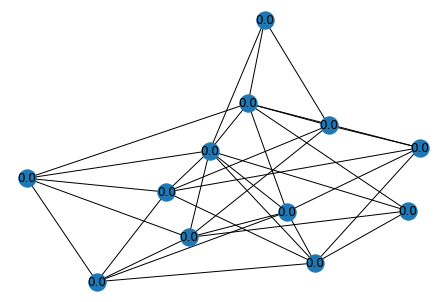

In [53]:
os.environ["WANDB_MODE"] = WANDB_MODE 

SWEEP_ID = wandb.sweep(sweep_config, project=PROJECT_NAME)
wandb.agent(SWEEP_ID, project=PROJECT_NAME, function=start_agent_envelope, count=500)

In [54]:
jljkl = sdfljldf/0

NameError: name 'sdfljldf' is not defined

# Load graph datasets

In [ ]:
import os

os.system("git clone https://github.com/KarolisMart/SPECTRE.git")


from argparse import ArgumentParser
import os
import numpy as np
import torch
import torch.nn.functional as F
#import pytorch_lightning as pl
import networkx as nx
from torch.utils.data import random_split, DataLoader, Dataset
from scipy.spatial import Delaunay
#from torch_geometric.datasets import QM9
#from rdkit import Chem
#from torch_geometric.utils import dense_to_sparse, to_dense_adj, to_networkx

#from util.eval_helper import degree_stats, orbit_stats_all, clustering_stats, spectral_stats, eigval_stats, compute_list_eigh, spectral_filter_stats
#from util.molecular_eval import BasicMolecularMetrics


class SpectreGraphDataset(Dataset):
    def __init__(self, data_file):
        """ This class can be used to load the comm20, sbm and planar datasets. """
        base_path = 'SPECTRE/data/'
        filename = os.path.join(base_path, data_file)
        self.adjs, self.eigvals, self.eigvecs, self.n_nodes, self.max_eigval, self.min_eigval, self.same_sample, self.n_max = torch.load(
            filename)
        print(f'Dataset {filename} loaded from file')

    def __len__(self):
        return len(self.adjs)

    def __getitem__(self, idx):
        adj = self.adjs[idx]
        n = adj.shape[-1]
        X = torch.ones(n, 1, dtype=torch.float)
        y = torch.zeros([1, 0]).float()
        edge_index, _ = torch_geometric.utils.dense_to_sparse(adj)
        edge_attr = torch.zeros(edge_index.shape[-1], 2, dtype=torch.float)
        edge_attr[:, 1] = 1
        num_nodes = n * torch.ones(1, dtype=torch.long)
        data = torch_geometric.data.Data(x=X, edge_index=edge_index, edge_attr=edge_attr,
                                         y=y, idx=idx, n_nodes=num_nodes)
        return data


class PlanarDataset(SpectreGraphDataset):
    def __init__(self):
        super().__init__('planar_64_200.pt')


PlanarDataset()



In [ ]:

adjs, eigvals, eigvecs, n_nodes, max_eigval, min_eigval, same_sample, n_max = torch.load('SPECTRE/data/planar_64_200.pt')
adjs

In [ ]:
graphs = adjs
test_len = int(round(len(graphs) * 0.2))
train_len = int(round((len(graphs) - test_len) * 0.8))
val_len = len(graphs) - train_len - test_len
print(f'Dataset sizes: train {train_len}, val {val_len}, test {test_len}')
splits = random_split(graphs, [train_len, val_len, test_len], generator=torch.Generator().manual_seed(1234))

### next try:

In [ ]:
os.system("pip install omegaconf")
os.system("pip install pytorch_lightning")

In [ ]:
os.system("pip install overrides")

In [ ]:

import os
os.system("git clone https://github.com/cvignac/DiGress.git")
os.system("cp -r DiGress/src src/")


import torch
from torch.utils.data import random_split, Dataset
import torch_geometric.utils

from src.datasets.abstract_dataset import AbstractDataModule, AbstractDatasetInfos


class SpectreGraphDataset(Dataset):
    def __init__(self, data_file):
        """ This class can be used to load the comm20, sbm and planar datasets. """
        base_path = os.path.join(os.path.dirname(os.path.realpath(__file__)), os.pardir, os.pardir, 'data')
        filename = os.path.join(base_path, data_file)
        self.adjs, self.eigvals, self.eigvecs, self.n_nodes, self.max_eigval, self.min_eigval, self.same_sample, self.n_max = torch.load(
            filename)
        print(f'Dataset {filename} loaded from file')

    def __len__(self):
        return len(self.adjs)

    def __getitem__(self, idx):
        adj = self.adjs[idx]
        n = adj.shape[-1]
        X = torch.ones(n, 1, dtype=torch.float)
        y = torch.zeros([1, 0]).float()
        edge_index, _ = torch_geometric.utils.dense_to_sparse(adj)
        edge_attr = torch.zeros(edge_index.shape[-1], 2, dtype=torch.float)
        edge_attr[:, 1] = 1
        num_nodes = n * torch.ones(1, dtype=torch.long)
        data = torch_geometric.data.Data(x=X, edge_index=edge_index, edge_attr=edge_attr,
                                         y=y, idx=idx, n_nodes=num_nodes)
        return data

class SpectreGraphDataModule(AbstractDataModule):
    def __init__(self, cfg, n_graphs=200):
        super().__init__(cfg)
        self.n_graphs = n_graphs
        self.prepare_data()
        self.inner = self.train_dataloader()

    def __getitem__(self, item):
        return self.inner[item]

    def prepare_data(self, graphs):
        test_len = int(round(len(graphs) * 0.2))
        train_len = int(round((len(graphs) - test_len) * 0.8))
        val_len = len(graphs) - train_len - test_len
        print(f'Dataset sizes: train {train_len}, val {val_len}, test {test_len}')
        splits = random_split(graphs, [train_len, val_len, test_len], generator=torch.Generator().manual_seed(1234))

        datasets = {'train': splits[0], 'val': splits[1], 'test': splits[2]}
        super().prepare_data(datasets)

class Comm20Dataset(SpectreGraphDataset):
    def __init__(self):
        super().__init__('community_12_21_100.pt')


class SBMDataset(SpectreGraphDataset):
    def __init__(self):
        super().__init__('sbm_200.pt')


class PlanarDataset(SpectreGraphDataset):
    def __init__(self):
        super().__init__('planar_64_200.pt')

dataset = PlanarDataset()
dataset.prepare_data
dataset.datasets

# Quality Measure

In [ ]:
import os
os.system("pip install pyemd")
import networkx as nx

In [ ]:
import pyemd
import numpy as np
import concurrent.futures
from functools import partial
from scipy.linalg import toeplitz

from datetime import datetime


PRINT_TIME = False

def degree_worker(G):
    return np.array(nx.degree_histogram(G))

def degree_stats(graph_ref_list, graph_pred_list, is_parallel=True, compute_emd=False):
    ''' Compute the distance between the degree distributions of two unordered sets of graphs.
        Args:
            graph_ref_list, graph_target_list: two lists of networkx graphs to be evaluated
        '''
    sample_ref = []
    sample_pred = []
    # in case an empty graph is generated
    graph_pred_list_remove_empty = [
        G for G in graph_pred_list if not G.number_of_nodes() == 0
    ]

    prev = datetime.now()
    if is_parallel:
        with concurrent.futures.ThreadPoolExecutor() as executor:
            for deg_hist in executor.map(degree_worker, graph_ref_list):
                sample_ref.append(deg_hist)
        with concurrent.futures.ThreadPoolExecutor() as executor:
            for deg_hist in executor.map(degree_worker, graph_pred_list_remove_empty):
                sample_pred.append(deg_hist)
    else:
        for i in range(len(graph_ref_list)):
            degree_temp = np.array(nx.degree_histogram(graph_ref_list[i]))
            sample_ref.append(degree_temp)
        for i in range(len(graph_pred_list_remove_empty)):
            degree_temp = np.array(
                nx.degree_histogram(graph_pred_list_remove_empty[i]))
            sample_pred.append(degree_temp)

    # mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=gaussian_emd)
    # mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=emd)
    if compute_emd:
        # EMD option uses the same computation as GraphRNN, the alternative is MMD as computed by GRAN
        # mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=emd)
        mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=gaussian_emd)
    else:
        mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=gaussian_tv)
    # mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=gaussian)

    elapsed = datetime.now() - prev
    if PRINT_TIME:
        print('Time computing degree mmd: ', elapsed)
    return mmd_dist



def clustering_worker(param):
    G, bins = param
    clustering_coeffs_list = list(nx.clustering(G).values())
    hist, _ = np.histogram(
        clustering_coeffs_list, bins=bins, range=(0.0, 1.0), density=False)
    return hist


def clustering_stats(graph_ref_list,
                     graph_pred_list,
                     bins=100,
                     is_parallel=True, compute_emd=False):
    sample_ref = []
    sample_pred = []
    graph_pred_list_remove_empty = [
        G for G in graph_pred_list if not G.number_of_nodes() == 0
    ]

    prev = datetime.now()
    if is_parallel:
        with concurrent.futures.ThreadPoolExecutor() as executor:
            for clustering_hist in executor.map(clustering_worker,
                                                [(G, bins) for G in graph_ref_list]):
                sample_ref.append(clustering_hist)
        with concurrent.futures.ThreadPoolExecutor() as executor:
            for clustering_hist in executor.map(
                    clustering_worker, [(G, bins) for G in graph_pred_list_remove_empty]):
                sample_pred.append(clustering_hist)

        # check non-zero elements in hist
        # total = 0
        # for i in range(len(sample_pred)):
        #    nz = np.nonzero(sample_pred[i])[0].shape[0]
        #    total += nz
        # print(total)
    else:
        for i in range(len(graph_ref_list)):
            clustering_coeffs_list = list(nx.clustering(graph_ref_list[i]).values())
            hist, _ = np.histogram(
                clustering_coeffs_list, bins=bins, range=(0.0, 1.0), density=False)
            sample_ref.append(hist)

        for i in range(len(graph_pred_list_remove_empty)):
            clustering_coeffs_list = list(
                nx.clustering(graph_pred_list_remove_empty[i]).values())
            hist, _ = np.histogram(
                clustering_coeffs_list, bins=bins, range=(0.0, 1.0), density=False)
            sample_pred.append(hist)

    if compute_emd:
        # EMD option uses the same computation as GraphRNN, the alternative is MMD as computed by GRAN
        # mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=emd, sigma=1.0 / 10)
        mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=gaussian_emd, sigma=1.0 / 10, distance_scaling=bins)
    else:
        mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=gaussian_tv, sigma=1.0 / 10)

    elapsed = datetime.now() - prev
    if PRINT_TIME:
        print('Time computing clustering mmd: ', elapsed)
    return mmd_dist



# maps motif/orbit name string to its corresponding list of indices from orca output
motif_to_indices = {
    '3path': [1, 2],
    '4cycle': [8],
}
COUNT_START_STR = 'orbit counts:'


def edge_list_reindexed(G):
    idx = 0
    id2idx = dict()
    for u in G.nodes():
        id2idx[str(u)] = idx
        idx += 1

    edges = []
    for (u, v) in G.edges():
        edges.append((id2idx[str(u)], id2idx[str(v)]))
    return edges

def orca(graph):
    # tmp_fname = f'analysis/orca/tmp_{"".join(secrets.choice(ascii_uppercase + digits) for i in range(8))}.txt'
    tmp_fname = f'orca/tmp_{"".join(secrets.choice(ascii_uppercase + digits) for i in range(8))}.txt'
    tmp_fname = os.path.join(os.path.dirname(os.path.realpath(__file__)), tmp_fname)
    # print(tmp_fname, flush=True)
    f = open(tmp_fname, 'w')
    f.write(
        str(graph.number_of_nodes()) + ' ' + str(graph.number_of_edges()) + '\n')
    for (u, v) in edge_list_reindexed(graph):
        f.write(str(u) + ' ' + str(v) + '\n')
    f.close()
    output = sp.check_output(
        [str(os.path.join(os.path.dirname(os.path.realpath(__file__)), 'orca/orca')), 'node', '4', tmp_fname, 'std'])
    output = output.decode('utf8').strip()
    idx = output.find(COUNT_START_STR) + len(COUNT_START_STR) + 2
    output = output[idx:]
    node_orbit_counts = np.array([
        list(map(int,
                 node_cnts.strip().split(' ')))
        for node_cnts in output.strip('\n').split('\n')
    ])

    try:
        os.remove(tmp_fname)
    except OSError:
        pass

    return node_orbit_counts


def orbit_stats_all(graph_ref_list, graph_pred_list, compute_emd=False):
    total_counts_ref = []
    total_counts_pred = []

    graph_pred_list_remove_empty = [
        G for G in graph_pred_list if not G.number_of_nodes() == 0
    ]

    for G in graph_ref_list:
        orbit_counts = orca(G)
        orbit_counts_graph = np.sum(orbit_counts, axis=0) / G.number_of_nodes()
        total_counts_ref.append(orbit_counts_graph)

    for G in graph_pred_list:
        orbit_counts = orca(G)
        orbit_counts_graph = np.sum(orbit_counts, axis=0) / G.number_of_nodes()
        total_counts_pred.append(orbit_counts_graph)

    total_counts_ref = np.array(total_counts_ref)
    total_counts_pred = np.array(total_counts_pred)

    # mmd_dist = compute_mmd(
    #     total_counts_ref,
    #     total_counts_pred,
    #     kernel=gaussian,
    #     is_hist=False,
    #     sigma=30.0)

    # mmd_dist = compute_mmd(
    #         total_counts_ref,
    #         total_counts_pred,
    #         kernel=gaussian_tv,
    #         is_hist=False,
    #         sigma=30.0)  

    if compute_emd:
        # mmd_dist = compute_mmd(total_counts_ref, total_counts_pred, kernel=emd, sigma=30.0)
        # EMD option uses the same computation as GraphRNN, the alternative is MMD as computed by GRAN
        mmd_dist = compute_mmd(total_counts_ref, total_counts_pred, kernel=gaussian, is_hist=False, sigma=30.0)
    else:
        mmd_dist = compute_mmd(total_counts_ref, total_counts_pred, kernel=gaussian_tv, is_hist=False, sigma=30.0)
    return mmd_dist




def gaussian(x, y, sigma=1.0):
    support_size = max(len(x), len(y))
    # convert histogram values x and y to float, and make them equal len
    x = x.astype(float)
    y = y.astype(float)
    if len(x) < len(y):
        x = np.hstack((x, [0.0] * (support_size - len(x))))
    elif len(y) < len(x):
        y = np.hstack((y, [0.0] * (support_size - len(y))))

    dist = np.linalg.norm(x - y, 2)
    return np.exp(-dist * dist / (2 * sigma * sigma))


def gaussian_tv(x, y, sigma=1.0):  
    support_size = max(len(x), len(y))
    # convert histogram values x and y to float, and make them equal len
    x = x.astype(float)
    y = y.astype(float)
    if len(x) < len(y):
        x = np.hstack((x, [0.0] * (support_size - len(x))))
    elif len(y) < len(x):
        y = np.hstack((y, [0.0] * (support_size - len(y))))

    dist = np.abs(x - y).sum() / 2.0
    return np.exp(-dist * dist / (2 * sigma * sigma))


def kernel_parallel_unpacked(x, samples2, kernel):
    d = 0
    for s2 in samples2:
        d += kernel(x, s2)
    return d


def kernel_parallel_worker(t):
    return kernel_parallel_unpacked(*t)




def disc(samples1, samples2, kernel, is_parallel=True, *args, **kwargs):
    ''' Discrepancy between 2 samples '''
    d = 0

    if not is_parallel:
        for s1 in samples1:
            for s2 in samples2:
                d += kernel(s1, s2, *args, **kwargs)
    else:
        with concurrent.futures.ThreadPoolExecutor() as executor:
            for dist in executor.map(kernel_parallel_worker, [
                    (s1, samples2, partial(kernel, *args, **kwargs)) for s1 in samples1
            ]):
                d += dist
    if len(samples1) * len(samples2) > 0:
        d /= len(samples1) * len(samples2)
    else:
        d = 1e+6
    #print('error')
    return d


def compute_mmd(samples1, samples2, kernel, is_hist=True, *args, **kwargs):
    ''' MMD between two samples '''
    # normalize histograms into pmf
    if is_hist:
        samples1 = [s1 / (np.sum(s1) + 1e-6) for s1 in samples1]
        samples2 = [s2 / (np.sum(s2) + 1e-6) for s2 in samples2]
    print(samples1)
    return disc(samples1, samples1, kernel, *args, **kwargs) + disc(samples2, samples2, kernel, *args, **kwargs) - \
                2 * disc(samples1, samples2, kernel, *args, **kwargs)


def compute_emd(samples1, samples2, kernel, is_hist=True, *args, **kwargs):
    ''' EMD between average of two samples '''
    # normalize histograms into pmf
    if is_hist:
        samples1 = [np.mean(samples1)]
        samples2 = [np.mean(samples2)]
    return disc(samples1, samples2, kernel, *args,
                            **kwargs), [samples1[0], samples2[0]]



def compute_mmd_stats(graphs_ref_nx, graphs_pred_nx):
    return degree_stats(graphs_ref_nx, graphs_pred_nx), clustering_stats(graphs_ref_nx, graphs_pred_nx)

In [ ]:
samples1 = [np.array([1,2,3.0]),  np.array([1,20,4.0])]
samples2 = [np.array([1,2,3.5]),  np.array([1,20,4.5])]

compute_mmd(samples1, samples2, kernel=gaussian_tv)

In [ ]:
samples1 = [np.array([1,200,3.0]),  np.array([1,20,4.0])]
samples2 = [np.array([1,2,3.01]),  np.array([1,20,4.01])]

compute_mmd(samples1, samples2, kernel=gaussian_tv)

In [ ]:
graph_ref_list = [nx.erdos_renyi_graph(15, 0.5) for _ in range(15) ]
graph_pred_list = [nx.erdos_renyi_graph(15, 0.5) for _ in range(15) ]

degree_stats(graph_ref_list, graph_pred_list)

In [ ]:
graph_ref_list = [nx.erdos_renyi_graph(15, 0.5) for _ in range(15) ]
graph_pred_list = [nx.erdos_renyi_graph(15, 0.9) for _ in range(15) ]

degree_stats(graph_ref_list, graph_pred_list)

In [ ]:
graph_ref_list = [nx.erdos_renyi_graph(15, 0.1) for _ in range(15) ]
graph_pred_list = [nx.erdos_renyi_graph(15, 0.5) for _ in range(15) ]

clustering_stats(graph_ref_list, graph_pred_list)